### Introduction 
This notebook is created based on this research paper [**PubMed 200k RCT:
a Dataset for Sequential Sentence Classification in Medical Abstracts**](https://arxiv.org/pdf/1710.06071.pdf)<br>

The summary of this reseach paper is that, it converts medical research paper **Abstract's** each sentence to a category (background, objective, methods, results, conclusions).

### Getting the data
Good thing is that data is publicly available.

In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (33/33), 177.08 MiB | 20.09 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [2]:
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
!ls /kaggle/working/pubmed-rct/PubMed_20k_RCT

dev.txt  test.txt  train.txt


`dev.txt` is validation set <br>
`test.txt` is test set and<br>
`train.txt` is train set

In [4]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
import os 
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

### Preprocessing data

In [6]:
def read_lines(filename):
    with open(filename) as file:
        return file.readlines()

In [7]:
filenames[0]

'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt'

In [8]:
train_file = read_lines(filename=filenames[1])
train_file[:10]

['###24290286\n',
 'BACKGROUND\tIgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .\n',
 'BACKGROUND\tIt is not clear whether these patients would benefit from antifungal treatment .\n',
 'OBJECTIVE\tWe sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are IgE sensitized to A fumigatus .\n',
 'METHODS\tAsthmatic patients who were IgE sensitized to A fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .\n',
 'METHODS\tPrimary outcomes were improvement in quality of life at the end of the treatment period and a reduction in the number of severe exacerbations over the @ months of the study .\n',
 'RESULTS\tSixty-five patients were randomized .

In [9]:
def preprocess_text(filename):
    
    input_lines = read_lines(filename)

    abstract_lines = ""
    abstracts = []

    for line in input_lines:
        if line.startswith("###"):
            abstract_lines = ""

        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines()

            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}
                line_split = abstract_line.split("\t")
                line_data["target"] = line_split[0]
                line_data["text"] = line_split[1].lower()
                line_data["line_number"] = abstract_line_number + 1
                line_data["total_lines"] = len(abstract_line_split)
                abstracts.append(line_data)
        else:
            abstract_lines += line
    
    return abstracts

In [10]:
abstracts = preprocess_text(filename=filenames[0])
abstracts[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 1,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 2,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 3,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 4,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [11]:
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

### Visualizing Data

In [12]:
train_samples = preprocess_text(filename=data_dir + "train.txt")
dev_samples = preprocess_text(filename=data_dir + "dev.txt")
test_samples = preprocess_text(filename=data_dir + "test.txt")

In [13]:
import pandas as pd

In [14]:
train_df = pd.DataFrame(train_samples)
dev_df = pd.DataFrame(dev_samples)
test_df = pd.DataFrame(test_samples)

In [15]:
train_df

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,1,12
1,METHODS,a total of @ patients with primary knee oa wer...,2,12
2,METHODS,outcome measures included pain reduction and i...,3,12
3,METHODS,pain was assessed using the visual analog pain...,4,12
4,METHODS,secondary outcome measures included the wester...,5,12
...,...,...,...,...
180035,RESULTS,for the absolute change in percent atheroma vo...,8,12
180036,RESULTS,"for pav , a significantly greater percentage o...",9,12
180037,RESULTS,both strategies had acceptable side effect pro...,10,12
180038,CONCLUSIONS,"compared with standard statin monotherapy , th...",11,12


In [16]:
train_df["target"].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

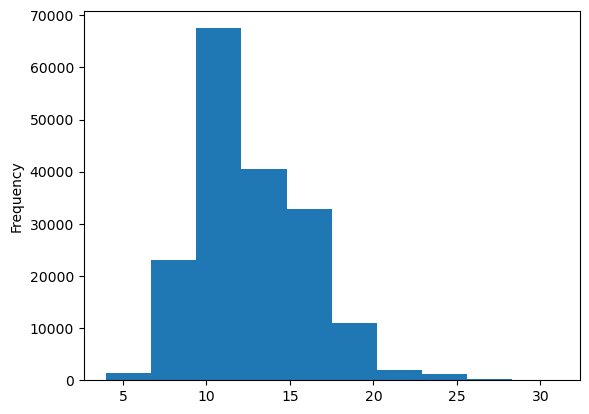

In [17]:
train_df["total_lines"].plot.hist();

In [18]:
len(train_df["text"]), len(dev_df["text"]), len(test_df["text"])

(180040, 30212, 30135)

### Splitting Data

In [19]:
train_sentences = train_df["text"]
val_sentences = dev_df["text"]
test_sentences = test_df["text"]

In [20]:
len(val_sentences)

30212

In [21]:
train_target = train_df["target"]
val_target = dev_df["target"]
test_target = test_df["target"]

### `OneHotEncoder`

In [22]:
from sklearn.preprocessing import OneHotEncoder

In [23]:
one_hot_encoder = OneHotEncoder(sparse=False)
train_target_hot_encoder = one_hot_encoder.fit_transform(train_target.to_numpy().reshape(-1,1)) 
val_target_hot_encoder = one_hot_encoder.fit_transform(val_target.to_numpy().reshape(-1,1)) 
test_target_hot_encoder = one_hot_encoder.fit_transform(test_target.to_numpy().reshape(-1,1)) 

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [24]:
train_target_hot_encoder

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### `LabelEncoder`

In [25]:
from sklearn.preprocessing import LabelEncoder

In [26]:
label_encoder = LabelEncoder()
train_target_label_encoder = label_encoder.fit_transform(train_target.to_numpy().reshape(-1,1))
val_target_label_encoder = label_encoder.fit_transform(val_target.to_numpy().reshape(-1,1))
test_target_label_encoder = label_encoder.fit_transform(test_target.to_numpy().reshape(-1,1))

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [27]:
len(label_encoder.classes_), label_encoder.classes_

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

### `model_0`: Baseline

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [29]:
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("multinomialNB", MultinomialNB())
])

In [30]:
model_0.fit(train_sentences, train_target_label_encoder)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('multinomialNB', MultinomialNB())])

### Evaluation function

In [31]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [32]:
def calculate_results(y_true, y_pred):
    """
    returns a dictionary of accuracy_score, precission, recall and f1_score
    """
    precission, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    acc_score = accuracy_score(y_true, y_pred) * 100
    
    results = {
        "accuracy_score": acc_score,
        "precission": precission,
        "recall": recall,
        "f1_score": f1_score
    }
    return results

In [33]:
baseline_results = calculate_results(val_target_label_encoder, model_0.predict(val_sentences))
baseline_results

{'accuracy_score': 72.1832384482987,
 'precission': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1_score': 0.6989250353450294}

### Text vectorization (tokenization)

In [34]:
from tensorflow.keras.layers import TextVectorization

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [35]:
import numpy as np

In [36]:
sentences_word_size = [len(sentence.split()) for sentence in train_sentences]
sentence_length = np.percentile(sentences_word_size, 95) # gives the size of sentence length for 95% sentence
sentence_length

55.0

In [37]:
max_tokens = 68000 # in the paper, for 20k dataset maximum vocabulary is 68k

In [38]:
text_vectorization = TextVectorization(max_tokens=max_tokens,
                                      output_sequence_length=int(sentence_length))

In [39]:
text_vectorization.adapt(train_sentences)

In [40]:
import random

In [41]:
random_sentence = random.choice(train_sentences)
print(random_sentence)
print(f"After tokenization {text_vectorization(random_sentence)}")

bisphosphonates ( bps ) are frequently used in the treatment of osteoporosis and have the ability to increase lumbar spine bone mineral density ( l-bmd ) .
After tokenization [ 8311 11724    58  1008    98     5     2    19     4  2858     3    99
     2   805     6   179  1244  1559   410  2051  1009 18502     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0]


In [42]:
print(f"5 most common words: {text_vectorization.get_vocabulary()[:5]}")
print(f"5 least common words: {text_vectorization.get_vocabulary()[-5:]}")

5 most common words: ['', '[UNK]', 'the', 'and', 'of']
5 least common words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


### Embedding

In [43]:
from tensorflow.keras.layers import Embedding

In [44]:
embedding = Embedding(input_dim=max_tokens, # 68000 set earlier from paper
                     output_dim=128, # multiple of 8 can be 64, 128, 256, 512
                     mask_zero=True) # increase the computaional power for 0 

In [45]:
random_sentence = random.choice(train_sentences)
print(f"Sentence before embedding: {random_sentence}")
embedding(text_vectorization([random_sentence]))

Sentence before embedding: fasting blood samples were taken before and after each phase of the study to quantify markers of systemic inflammation .


<tf.Tensor: shape=(1, 55, 128), dtype=float32, numpy=
array([[[-0.00012817, -0.03939487,  0.02232615, ...,  0.03656681,
         -0.01088916, -0.03923283],
        [ 0.03168413, -0.01121299,  0.03777564, ...,  0.03966803,
          0.02798216,  0.00598665],
        [ 0.04946986, -0.03433428, -0.03927789, ..., -0.02028835,
          0.02786561,  0.02564894],
        ...,
        [-0.02698492,  0.00044972,  0.03142095, ..., -0.03195389,
         -0.01524415,  0.0431949 ],
        [-0.02698492,  0.00044972,  0.03142095, ..., -0.03195389,
         -0.01524415,  0.0431949 ],
        [-0.02698492,  0.00044972,  0.03142095, ..., -0.03195389,
         -0.01524415,  0.0431949 ]]], dtype=float32)>

**Note:** If we see the shape of the embedded sentence, we will notice it is (1, 55, 128)
which means from every sentence we will take 55 words and each word will be represented with 128 shape matrix.

### Creating Datasets

In [46]:
import tensorflow as tf

In [47]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_target_hot_encoder))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_target_hot_encoder))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_target_hot_encoder))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [48]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### `model_1`: Conv1D

In [49]:
inputs = tf.keras.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorization(inputs)
token_embeddings = embedding(text_vectors)
x = tf.keras.layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = tf.keras.layers.GlobalMaxPool1D()(x)
outputs = tf.keras.layers.Dense(5, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_conv1D")

In [50]:
model_1.summary()

Model: "model_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 55, 128)           8704000   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 5)                

In [51]:
model_1.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [52]:
history_conv1D = model_1.fit(train_dataset,
                             steps_per_epoch=int(0.1 * len(train_dataset)),
                             epochs=3,
                             validation_data=val_dataset,
                             validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 42s 60ms/step - loss: 0.8360 - accuracy: 0.6861 - val_loss: 0.5924 - val_accuracy: 0.7832
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.5798 - accuracy: 0.7892 - val_loss: 0.5502 - val_accuracy: 0.7965
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.5454 - accuracy: 0.7992 - val_loss: 0.5272 - val_accuracy: 0.8108


In [53]:
model_1.evaluate(val_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5273 - accuracy: 0.8054


[0.5272518396377563, 0.8054084181785583]

In [54]:
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[5.8571887e-01, 1.1673297e-01, 3.7276526e-03, 2.9069117e-01,
        3.1293319e-03],
       [2.3421918e-01, 6.7683351e-01, 3.9236029e-04, 8.4743924e-02,
        3.8110062e-03],
       [1.6181326e-01, 9.5011853e-03, 2.5165037e-03, 8.2602423e-01,
        1.4480912e-04],
       ...,
       [1.8595823e-04, 1.2031284e-03, 1.1164541e-02, 1.1586748e-04,
        9.8733056e-01],
       [3.2547168e-02, 5.3583413e-01, 3.6264479e-02, 3.8103204e-02,
        3.5725102e-01],
       [2.3991380e-02, 9.6891886e-01, 1.7736165e-03, 3.7555681e-03,
        1.5605682e-03]], dtype=float32)

In [55]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 1, 1])>

In [56]:
model_1_results = calculate_results(y_true=val_target_label_encoder,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy_score': 80.5408446974712,
 'precission': 0.8038041478615732,
 'recall': 0.805408446974712,
 'f1_score': 0.8038205289385393}

### `model_2`: Transfer learning

In [57]:
import tensorflow_hub as hub

**Note:** In the paper `GloVe` model was used as pretrained model, but we will use `universal-sentence-encoder`(USE)

In [58]:
universal_sentence_encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                            trainable=False,
                                            name="universal_sentence_encoder")

In [59]:
random_sentence = random.choice(train_sentences)
print(random_sentence)
print(f"After USN:\n{universal_sentence_encoder([random_sentence])[0][:30]}")

further studies of its efficacy , mechanism of action , and pharmacogenetics of response are warranted .
After USN:
[ 0.03383415  0.03648208 -0.04869013 -0.03298486 -0.06084358  0.04916127
  0.02318311 -0.05276518  0.02649128  0.04519555  0.02617349 -0.02775973
  0.07991453  0.06497519 -0.0495594   0.00548029 -0.03732692 -0.03565711
  0.01667364 -0.07047299  0.04493442  0.02644244 -0.04065761  0.02330058
 -0.03951514  0.00408411 -0.00461459  0.01328816  0.02559067  0.03183977]


In [60]:
inputs = tf.keras.Input(shape=[], dtype=tf.string)
x = universal_sentence_encoder(inputs)
x = tf.keras.layers.Dense(64, activation="relu")(x)
outputs = tf.keras.layers.Dense(5, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_USN")

In [61]:
model_2.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [62]:
model_2.summary()

Model: "model_2_USN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 64)                32832     
                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                                 
Total params: 256,830,981
Trainable params: 33,157
Non-trainable params: 256,797,824
_________________________________________________________________


In [63]:
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=round(0.1*len(train_dataset)),
                              validation_data=val_dataset,
                              validation_steps=round(0.1*len(train_dataset)))

Epoch 1/3
563/563 [==============================] - 15s 22ms/step - loss: 0.9479 - accuracy: 0.6428 - val_loss: 0.8043 - val_accuracy: 0.6890
Epoch 2/3
563/563 [==============================] - 18s 31ms/step - loss: 0.7816 - accuracy: 0.6937 - val_loss: 0.7599 - val_accuracy: 0.7053
Epoch 3/3
563/563 [==============================] - 12s 22ms/step - loss: 0.7681 - accuracy: 0.7063 - val_loss: 0.7503 - val_accuracy: 0.7089


In [64]:
model_2.evaluate(val_dataset)

945/945 [==============================] - 11s 11ms/step - loss: 0.7576 - accuracy: 0.7068


[0.7576447129249573, 0.7068052291870117]

In [65]:
model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs

945/945 [==============================] - 11s 11ms/step


array([[0.4557768 , 0.32958177, 0.00322217, 0.2045929 , 0.00682638],
       [0.36930537, 0.49824333, 0.00396896, 0.12573041, 0.00275188],
       [0.21005248, 0.17691527, 0.01947748, 0.55510616, 0.03844864],
       ...,
       [0.0023505 , 0.00649608, 0.06995347, 0.00112759, 0.9200724 ],
       [0.00444906, 0.04269817, 0.21857086, 0.0019634 , 0.7323185 ],
       [0.17235762, 0.17930518, 0.5785518 , 0.00781621, 0.06196915]],
      dtype=float32)

In [66]:
model_2_pred = tf.argmax(model_2_pred_probs, axis=1)
model_2_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [67]:
model_2_results = calculate_results(y_true=val_target_label_encoder,
                                    y_pred=model_2_pred)
model_2_results

{'accuracy_score': 70.68052429498212,
 'precission': 0.7066653161019508,
 'recall': 0.7068052429498213,
 'f1_score': 0.7033081905633851}

### Character vectorization

In [68]:
def split_char(sentence):
    return " ".join(list(sentence))

In [69]:
split_char(random_sentence)

'f u r t h e r   s t u d i e s   o f   i t s   e f f i c a c y   ,   m e c h a n i s m   o f   a c t i o n   ,   a n d   p h a r m a c o g e n e t i c s   o f   r e s p o n s e   a r e   w a r r a n t e d   .'

In [70]:
train_chars = [split_char(sentence) for sentence in train_sentences]
val_chars = [split_char(sentence) for sentence in val_sentences]
test_chars = [split_char(sentence) for sentence in test_sentences]

In [71]:
train_sentences[0], val_sentences[0]

('to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'ige sensitization to aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .')

In [72]:
len(val_chars), len(val_sentences)

(30212, 30212)

In [73]:
train_chars[0]

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [74]:
train_chars_length = [len(sentence) for sentence in train_sentences]
output_seq_length = np.percentile(train_chars_length, 95)
output_seq_length

290.0

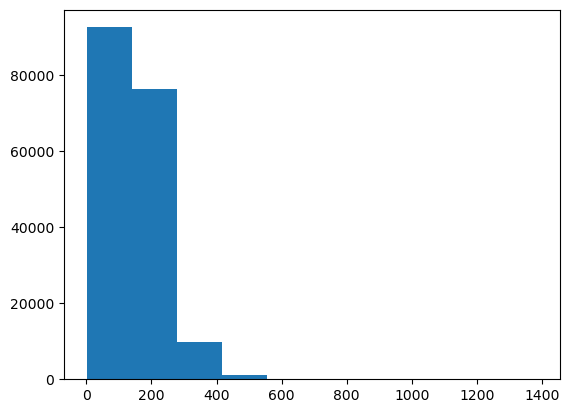

In [75]:
import matplotlib.pyplot as plt
plt.hist(train_chars_length);

In [76]:
import string

In [77]:
alphabet = string.ascii_lowercase + string.punctuation 
alphabet

'abcdefghijklmnopqrstuvwxyz!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

**Note:** In our dataset(`PubMed` digits replaced with @) there is no numbers, so we omitted `string.digits` but,<br>
if we have used `PubMed` (digits not replaced with @) we would have included `string.digits`

In [78]:
NUM_CHAR_TOKENS = len(alphabet) + 2 # extra 2 is for space and OOV token
NUM_CHAR_TOKENS

60

In [79]:
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS, 
                                    output_sequence_length=int(output_seq_length)) # 290

In [80]:
char_vectorizer.adapt(train_chars)

In [81]:
random_train_chars = random.choice(train_chars)
print(f"Sentence in character level:")
print(f"{random_train_chars}")
print(f"After vectorization:")
char_vectorizer(random_train_chars)

Sentence in character level:
s u p p l e m e n t a l   e b r t   a f t e r   t a r g i t   w a s   n e c e s s a r y   i n   @   %   - l s b -   @   o f   @   - r s b -   o f   p a t i e n t s   w h o   r e c e i v e d   t a r g i t   (   @   %   p r e p a t h o l o g y   ,   @   %   p o s t p a t h o l o g y   )   .
After vectorization:


<tf.Tensor: shape=(290,), dtype=int64, numpy=
array([ 9, 16, 14, 14, 12,  2, 15,  2,  6,  3,  5, 12,  2, 22,  8,  3,  5,
       17,  3,  2,  8,  3,  5,  8, 18,  4,  3, 20,  5,  9,  6,  2, 11,  2,
        9,  9,  5,  8, 19,  4,  6, 12,  9, 22,  7, 17,  8,  9, 22,  7, 17,
       14,  5,  3,  4,  2,  6,  3,  9, 20, 13,  7,  8,  2, 11,  2,  4, 21,
        2, 10,  3,  5,  8, 18,  4,  3, 14,  8,  2, 14,  5,  3, 13,  7, 12,
        7, 18, 19, 14,  7,  9,  3, 14,  5,  3, 13,  7, 12,  7, 18, 19,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,

In [82]:
print(f"5 most common words: {char_vectorizer.get_vocabulary()[:5]}")
print(f"5 least common words: {char_vectorizer.get_vocabulary()[-5:]}")

5 most common words: ['', '[UNK]', 'e', 't', 'i']
5 least common words: ['k', 'x', 'z', 'q', 'j']


### Character Embedding

In [83]:
character_embedding = Embedding(input_dim=NUM_CHAR_TOKENS,
                               output_dim=25,
                               mask_zero=True,
                               name="character_embedding")

In [84]:
random_sentence = random.choice(train_chars)
print(f"Sentence before embedding: {random_sentence}")
character_embedding(char_vectorizer([random_sentence]))

Sentence before embedding: w e   d e s c r i b e   o u r   s t u d y   p r o t o c o l   a n d   t h e   c h a l l e n g e s   i n   c o n d u c t i n g   p r o p h y l a c t i c   h y p o t h e r m i a   r e s e a r c h   i n   t b i   .


<tf.Tensor: shape=(1, 290, 25), dtype=float32, numpy=
array([[[ 0.0007291 ,  0.04356612, -0.03044465, ...,  0.01727993,
         -0.00709629, -0.0046344 ],
        [-0.0473369 , -0.01363375,  0.0459983 , ...,  0.01621315,
          0.02127871, -0.02413505],
        [-0.03943112, -0.03216283,  0.01223335, ..., -0.02297915,
         -0.030152  , -0.03551695],
        ...,
        [-0.0270507 ,  0.03448885,  0.02616471, ..., -0.03756145,
          0.04666164, -0.04407743],
        [-0.0270507 ,  0.03448885,  0.02616471, ..., -0.03756145,
          0.04666164, -0.04407743],
        [-0.0270507 ,  0.03448885,  0.02616471, ..., -0.03756145,
          0.04666164, -0.04407743]]], dtype=float32)>

### `model_3`: conv1D character embedding

In [85]:
inputs = tf.keras.layers.Input(shape=(1,), dtype="string")
char_vector = char_vectorizer(inputs)
char_embedding = character_embedding(char_vector)
x = tf.keras.layers.Conv1D(64, 5, padding="same", activation="relu")(char_embedding)
x = tf.keras.layers.GlobalMaxPool1D()(x)
outputs = tf.keras.layers.Dense(5, activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs)

In [86]:
model_3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 290)              0         
 ectorization)                                                   
                                                                 
 character_embedding (Embedd  (None, 290, 25)          1500      
 ing)                                                            
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                             

In [87]:
len(val_chars), len(train_chars)

(30212, 180040)

In [88]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_target_hot_encoder))
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_target_hot_encoder))
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_target_hot_encoder))

train_char_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [89]:
train_char_dataset = train_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = val_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = test_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [90]:
model_3.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [91]:
history_3 = model_3.fit(train_char_dataset,
                       epochs=3,
                       steps_per_epoch=(0.1 * len(train_char_dataset)),
                       validation_data=val_char_dataset,
                       validation_steps=(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 6s 7ms/step - loss: 1.2687 - accuracy: 0.4918 - val_loss: 1.0575 - val_accuracy: 0.5875
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.0193 - accuracy: 0.5930 - val_loss: 0.9589 - val_accuracy: 0.6247
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9406 - accuracy: 0.6289 - val_loss: 0.8937 - val_accuracy: 0.6510


In [92]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 3s 4ms/step - loss: 0.9072 - accuracy: 0.6446


[0.9071982502937317, 0.6446114182472229]

In [93]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[0.09833182, 0.2684325 , 0.13948831, 0.4427677 , 0.0509796 ],
       [0.2652436 , 0.37612584, 0.01145698, 0.3137692 , 0.03340439],
       [0.10669392, 0.17066257, 0.19934376, 0.49146053, 0.03183932],
       ...,
       [0.01536008, 0.03114925, 0.15900446, 0.03914341, 0.7553428 ],
       [0.01642219, 0.0701465 , 0.4196501 , 0.04739154, 0.44638962],
       [0.20063917, 0.62690294, 0.09367764, 0.06365182, 0.01512842]],
      dtype=float32)

In [94]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 1, 3, ..., 4, 4, 1])>

In [95]:
model_3_results = calculate_results(y_true=val_target_label_encoder, 
                                    y_pred=model_3_preds)
model_3_results

{'accuracy_score': 64.46114126837018,
 'precission': 0.6454324799535738,
 'recall': 0.6446114126837018,
 'f1_score': 0.6348121243191746}

### `model_4`: combining pretrained token embeddings + character embeddings

In [96]:
from tensorflow.keras import layers

In [97]:
# 1. Token model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_pretrained_layer = universal_sentence_encoder(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_pretrained_layer)
token_model = tf.keras.Model(token_inputs, token_output)

# 2. Embedding model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embed = character_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embed) # 50 is given in paper as bi-directional it will be 25, but we take 24 as it is divisble by 8
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. concatenate 2 models
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. creating final model
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(256, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(5, activation="softmax")(final_dropout)

# 5. final model
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                        outputs=output_layer,
                        name="model_4_token_and_char_embeddings")

In [98]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 290)         0           ['char_input[0][0]']             
 orization)                                                                                       
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

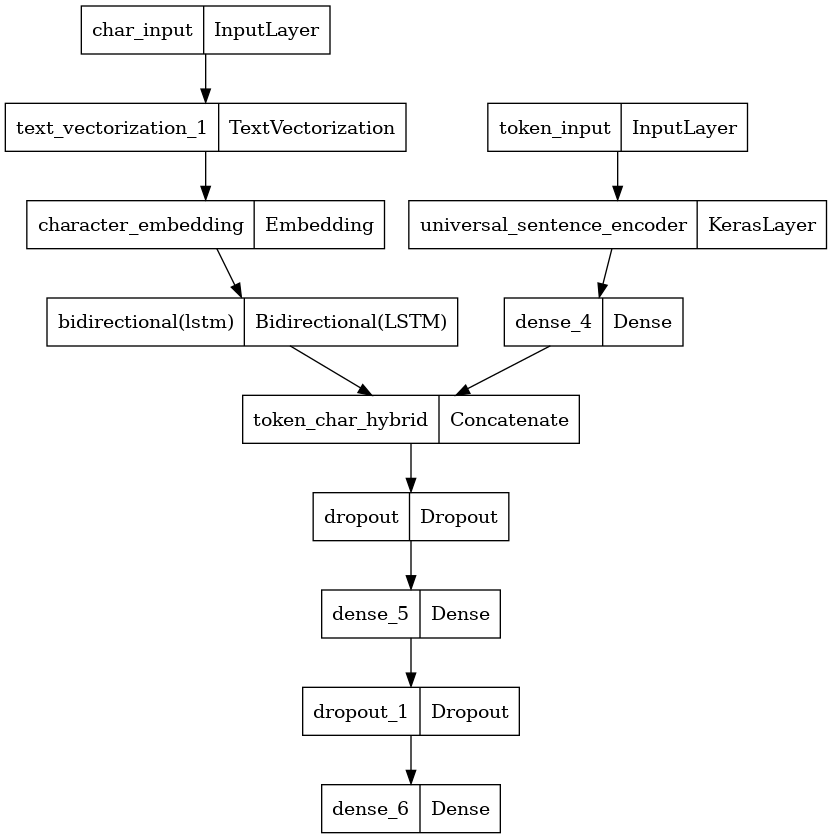

In [99]:
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [100]:
model_4.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [101]:
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_token_char_labels = tf.data.Dataset.from_tensor_slices(train_target_hot_encoder)
train_token_char_dataset = tf.data.Dataset.zip((train_token_char_data, train_token_char_labels))

train_token_char_dataset = train_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [102]:
val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_token_char_labels = tf.data.Dataset.from_tensor_slices(val_target_hot_encoder)
val_token_char_dataset = tf.data.Dataset.zip((val_token_char_data, val_token_char_labels))

val_token_char_dataset = val_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [103]:
train_token_char_dataset, val_token_char_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [104]:
model_4_history = model_4.fit(train_token_char_dataset,
                             epochs=3,
                             steps_per_epoch=(0.1 * len(train_token_char_dataset)),
                             validation_data=val_token_char_dataset,
                             validation_steps=(0.1 * len(val_token_char_dataset)))

Epoch 1/3
562/562 [==============================] - 48s 67ms/step - loss: 0.9586 - accuracy: 0.6211 - val_loss: 0.7805 - val_accuracy: 0.7046
Epoch 2/3
562/562 [==============================] - 30s 53ms/step - loss: 0.7861 - accuracy: 0.6961 - val_loss: 0.7128 - val_accuracy: 0.7253
Epoch 3/3
562/562 [==============================] - 27s 48ms/step - loss: 0.7600 - accuracy: 0.7085 - val_loss: 0.6814 - val_accuracy: 0.7461


In [105]:
model_4.evaluate(val_token_char_dataset)

945/945 [==============================] - 23s 24ms/step - loss: 0.6849 - accuracy: 0.7410


[0.6848782300949097, 0.7410300374031067]

In [106]:
model_4_pred_probs = model_4.predict(val_token_char_dataset)
model_4_pred_probs

945/945 [==============================] - 24s 23ms/step


array([[5.2690721e-01, 2.3088518e-01, 3.6253296e-03, 2.3328452e-01,
        5.2977270e-03],
       [3.3513770e-01, 5.1078749e-01, 2.5558867e-03, 1.5037990e-01,
        1.1389962e-03],
       [3.6289716e-01, 1.0458124e-01, 4.1003659e-02, 4.7211221e-01,
        1.9405726e-02],
       ...,
       [9.4310346e-04, 6.6635087e-03, 9.5328361e-02, 3.0932893e-04,
        8.9675570e-01],
       [7.9188133e-03, 6.0454965e-02, 2.6489991e-01, 2.8937457e-03,
        6.6383260e-01],
       [2.4046768e-01, 3.8495055e-01, 3.2083780e-01, 2.0734504e-02,
        3.3009470e-02]], dtype=float32)

In [107]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [108]:
model_4_results = calculate_results(y_true=val_target_label_encoder,
                                   y_pred=model_4_preds)
model_4_results

{'accuracy_score': 74.10300542830663,
 'precission': 0.7408499504069775,
 'recall': 0.7410300542830663,
 'f1_score': 0.7387246468780458}

### Creating positional embeddings

In [109]:
train_df["line_number"].value_counts()

1     15000
2     15000
3     15000
4     15000
5     14992
6     14949
7     14758
8     14279
9     13346
10    11981
11    10041
12     7892
13     5853
14     4152
15     2835
16     1861
17     1188
18      751
19      462
20      286
21      162
22      101
23       66
24       33
25       22
26       14
27        7
28        4
29        3
30        1
31        1
Name: line_number, dtype: int64

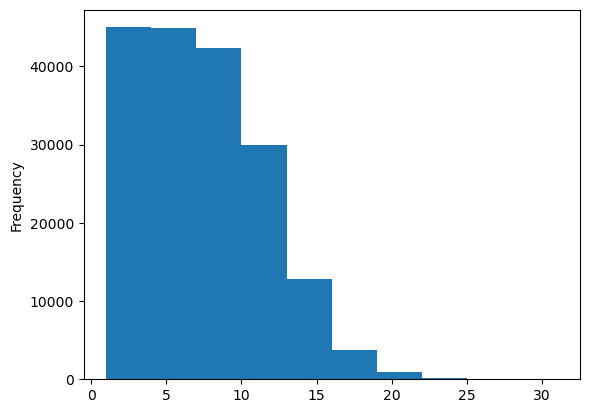

In [118]:
train_df["line_number"].plot.hist();

In [112]:
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"], depth=16)
val_line_numbers_one_hot = tf.one_hot(dev_df["line_number"], depth=16) 
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"], depth=16) 

In [113]:
train_line_numbers_one_hot[:20]

<tf.Tensor: shape=(20, 16), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
 

In [115]:
train_df["total_lines"].value_counts()

12    24468
11    23639
13    22113
10    19400
14    18438
15    14610
9     12285
16    10768
8      7464
17     7429
18     5202
7      3353
19     3344
20     2480
21     1281
6      1146
22      770
23      759
24      264
5       215
25      200
26      182
27       81
29       58
4        32
31       31
28       28
Name: total_lines, dtype: int64

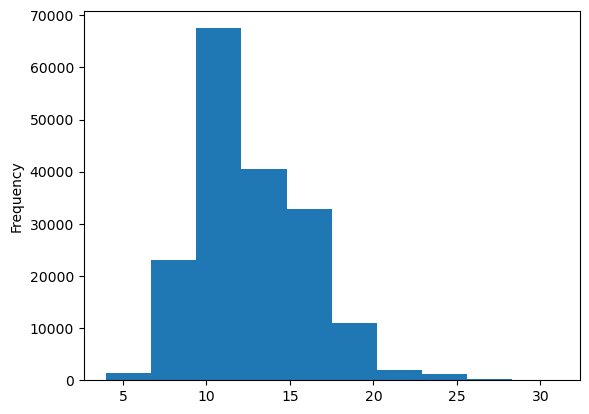

In [117]:
train_df["total_lines"].plot.hist();

In [125]:
np.percentile(train_df["total_lines"], 98)

21.0

In [126]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"], depth=21)
val_total_lines_one_hot = tf.one_hot(dev_df["total_lines"], depth=21)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"], depth=21)

In [127]:
train_total_lines_one_hot[:10]

<tf.Tensor: shape=(10, 21), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0